# Basic usage and comparison

This example will run through a basic comparison of `MultiHMCGibbs` with `NUTS` and `HMCGibbs` for a simple problem where all three methods should give the same results.  Our target distribution will be a 2D normal with some covariance.

In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz
import corner
import matplotlib.pyplot as plt

from numpyro.infer import MCMC, NUTS, HMCGibbs
from jax import random

from MultiHMCGibbs import MultiHMCGibbs

## The model

As with any Numpyro sampler we start with a model function for our distribution.

In [2]:
def model():
    x = numpyro.sample("x", dist.Normal(0.0, 2.0))
    y = numpyro.sample("y", dist.Normal(0.0, 2.0))
    numpyro.sample("obs", dist.Normal(x + y, 1.0), obs=jnp.array([1.0]))

## NUTS

To start we will use NUTS so we know what we are comparing to.

In [3]:
rng_key = random.PRNGKey(0)
hmc_key, rng_key = random.split(rng_key)

divergences per chain: [0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.462,1.491,-2.447,3.221,0.043,0.031,1197.0,1200.0,1.0
y,0.420,1.498,-2.312,3.307,0.044,0.033,1169.0,1379.0,1.0


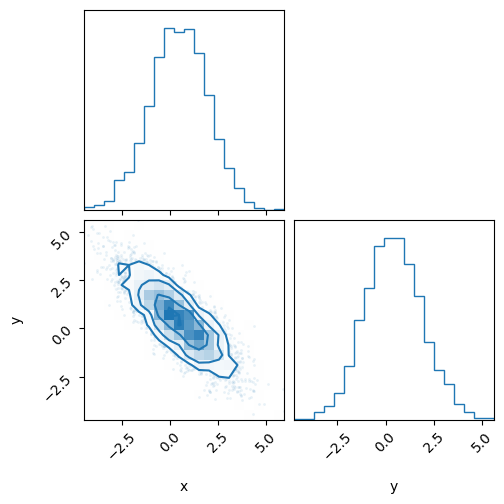

In [4]:
hmc_kernel = NUTS(model)
mcmc = MCMC(
    hmc_kernel,
    num_warmup=100,
    num_samples=1000,
    num_chains=4,
    chain_method='vectorized',
    progress_bar=False
)
mcmc.run(hmc_key)

inf_data_hmc = arviz.from_numpyro(mcmc)
print(f'divergences per chain: {inf_data_hmc.sample_stats.diverging.values.sum(axis=1)}')
display(arviz.summary(inf_data_hmc))
fig = corner.corner(inf_data_hmc, color='C0')

## MultiHMCGibbs

To use `MultiHMCGibbs` you need to create a list of HMC or NUTS kernels that wrap the same model, but each can have their own keywords such as `target_accept_prob` or `max_tree_depth`.  The other argument is a list of lists containing the **free** parameters for each of the inner kernels.  Internally each the sampler will:
1. Loop over the kernels in the list
2. Conditioned it on the non-free parameters
3. Re-calculate the likelihood and gradients at the new conditioned point
4. Step the kernel forward
5. Move on to the next kernel

After stepping the last kernel all the parameters will be updated and a single Gibbs step has been taken.

**Important**: All free parameters must be listed **exactly once** for the sampler to work.  If this is not the case a `ValueError` will be raised listing what values are either duplicated, extra, or missing from the list.

In [5]:
multigibbs_key, rng_key = random.split(rng_key)

divergences per chain per step:
 [[0 0 0 0]
 [0 0 0 0]]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.512,1.545,-2.279,3.448,0.080,0.057,376.0,669.0,1.00
y,0.355,1.552,-2.493,3.249,0.081,0.057,377.0,678.0,1.01


HMC (Blue)
MultiHMCGibbs (Orange)


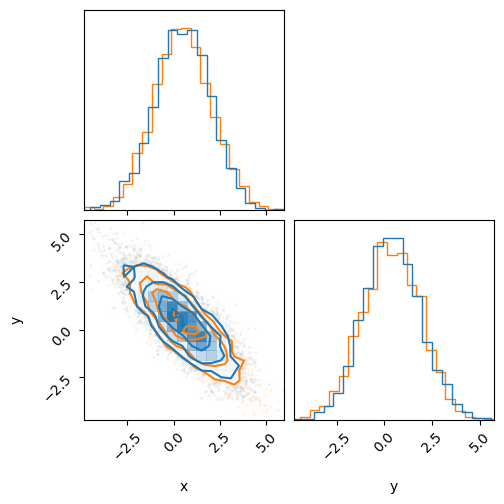

In [6]:
inner_kernels = [
    NUTS(model),
    NUTS(model)
]

outer_kernel = MultiHMCGibbs(
    inner_kernels,
    [['y'], ['x']]  # first updated y, then update x
)

mcmc_gibbs = MCMC(
    outer_kernel,
    num_warmup=100,
    num_samples=1000,
    num_chains=4,
    chain_method='vectorized',
    progress_bar=False
)
mcmc_gibbs.run(multigibbs_key)

inf_data_gibbs = arviz.from_numpyro(mcmc_gibbs)
print(f'divergences per chain per step:\n {inf_data_gibbs.sample_stats.diverging.values.sum(axis=1).T}')
display(arviz.summary(inf_data_gibbs))

print('HMC (Blue)')
print('MultiHMCGibbs (Orange)')
fig = corner.corner(inf_data_gibbs, color='C1')
_ = corner.corner(inf_data_hmc, fig=fig, color='C0')

We can see that the two samplers give the same results, a good indication that everything is working.

## HMCGibbs

For this simple model we can also do the conditioning on `y` by hand and use Numpyro's builtin `HMCGibbs` sampler.  Let's see how that compares.

Note: We will use `chian_method='sequential'` for this sampler because it does support `vectorized`.  We also don't have access to the `divergences` of the HMC kernel so those will not be reported either.

In [7]:
gibbs_key, rng_key = random.split(rng_key)

/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.459,1.445,-2.298,3.091,0.067,0.047,472.0,1299.0,1.01
y,0.425,1.438,-2.218,3.136,0.075,0.053,366.0,824.0,1.01


HMC (Blue)
MultiHMCGibbs (Orange)
HMCGibbs (Green)


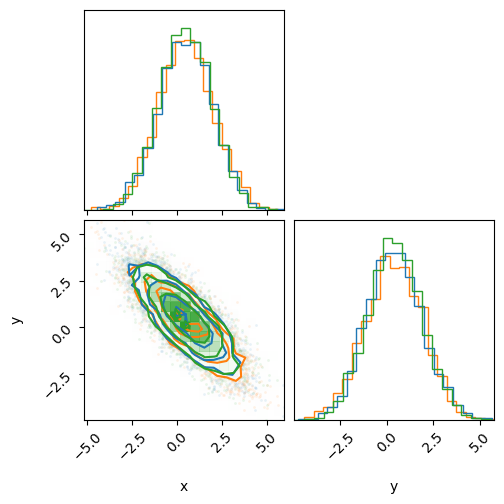

In [8]:
def gibbs_fn(rng_key, gibbs_sites, hmc_sites):
    y = hmc_sites['y']
    new_x = dist.Normal(0.8 * (1-y), jnp.sqrt(0.8)).sample(rng_key)
    return {'x': new_x}


kernel_gibbs_fn = HMCGibbs(hmc_kernel, gibbs_fn=gibbs_fn, gibbs_sites=['x'])

mcmc_gibbs_fn = MCMC(
    kernel_gibbs_fn,
    num_warmup=100,
    num_samples=1000,
    num_chains=4,
    chain_method='sequential',
    progress_bar=False
)

mcmc_gibbs_fn.run(gibbs_key)

inf_data_gibbs_fn = arviz.from_numpyro(mcmc_gibbs_fn)
display(arviz.summary(inf_data_gibbs_fn))

print('HMC (Blue)')
print('MultiHMCGibbs (Orange)')
print('HMCGibbs (Green)')
fig = corner.corner(inf_data_gibbs, color='C1')
_ = corner.corner(inf_data_hmc, fig=fig, color='C0')
_ = corner.corner(inf_data_gibbs_fn, fig=fig, color='C2')

As before, we see that this sampler gives the same results.